In [3]:
!pip -qq install torchutils

In [2]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

# Для чтения изображений с диска
from torchvision import io # input/output
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt

1. Убедись, что структура папок соответствует задаче классификации (либо приведите ее к формату, указанному ниже):

        `train`
        
            - class_1
            - class_2
            - ...
            - class_n
            
        `valid`

            - class_1
            - class_2
            - ...
            - class_n

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%cd Agricultural-crops/

/content/drive/MyDrive/Agricultural-crops


In [19]:
ls

test/  train/


In [13]:
# Распаковываем
!unzip -qq -o agricultural-images.zip

2. Создай `DataLoader` в для обучающей и валидационных выборок. Примените аугментации к изображениям.

In [5]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


In [6]:
preprocessor_train = T.Compose(
    [
        T.Resize((244, 244)),
        T.RandomHorizontalFlip(p=0.5), # Горизонтальное отражение с вероятностью 50%
        T.RandomRotation(15),          # Случайный поворот ±15 градусов
        T.ColorJitter(                 # Изменение цветовых параметров
        brightness=0.2,            # Яркость ±20%
        contrast=0.2,              # Контраст ±20%
        saturation=0.2,            # Насыщенность ±20%
        hue=0.1                    # Оттенок ±10%
    ),
        T.ToTensor()
    ])

preprocessor_test = T.Compose(
    [
        T.Resize((244, 244)),
        T.ToTensor()
    ])

In [7]:
import torchvision

train_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Agricultural-crops/train', transform=preprocessor_train)
test_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/Agricultural-crops/test', transform=preprocessor_test)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [9]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 630
    Root location: /content/drive/MyDrive/Agricultural-crops/train
    StandardTransform
Transform: Compose(
               Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
           )

In [10]:
# достаем из тренировочного датасета название классов и их номера (словарь) -> переваодим в список кортежей (ключ(наименование), значение(номер класса))
train_dataset.class_to_idx.items()
# меняем местами, чтоыб после предсказания метки класса легче было достать название понятное человеку
classes_dict = {value: key for key, value in train_dataset.class_to_idx.items()}
classes_dict

{0: 'Cherry',
 1: 'Coffee-plant',
 2: 'Cucumber',
 3: 'Fox_nut(Makhana)',
 4: 'Lemon',
 5: 'Olive-tree',
 6: 'Pearl_millet(bajra)',
 7: 'Tobacco-plant',
 8: 'almond',
 9: 'banana',
 10: 'cardamom',
 11: 'chilli',
 12: 'clove',
 13: 'coconut',
 14: 'cotton',
 15: 'gram',
 16: 'jowar',
 17: 'jute',
 18: 'maize',
 19: 'mustard-oil',
 20: 'papaya',
 21: 'pineapple',
 22: 'rice',
 23: 'soyabean',
 24: 'sugarcane',
 25: 'sunflower',
 26: 'tea',
 27: 'tomato',
 28: 'vigna-radiati(Mung)',
 29: 'wheat'}

3. Создай экземпляр предобученной модели: [torchvision models](https://pytorch.org/vision/stable/models.html). Можно взять любую модель для baseline, а дальше попробовать что-то более сложное.

In [11]:
# https://pytorch.org/vision/stable/models.html

from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [12]:
model.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [13]:
fake_batch = torch.randn(4, 3, 224, 224, device=DEVICE)
# tu.get_model_summary(model, fake_batch)

In [42]:
next(iter(train_loader))[0][0][0]

KeyboardInterrupt: 

5. Замени выходной слой форматом, который подходит под задачу: бинарная или многоклассовая классификация.

In [14]:
in_features = model.classifier[2].in_features

model.classifier = nn.Sequential(
    model.classifier[0],  # LayerNorm2d
    model.classifier[1],  # Flatten
    nn.Dropout(0.4),      # ← ваш Dropout (можно попробовать 0.2–0.5)
    nn.Linear(in_features, 30, bias=True)  # 30 классов
)

In [15]:
# проверили, изменился ли последний слой
model
# Проверяем, какие параметры обучаемые (все)
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
# замораживаем все слои
for param in model.parameters():
    param.requires_grad = False

In [203]:
# проверили, что все заморожены - False

# for p in model.parameters():
#   print(p.requires_grad)

In [17]:
# «Размораживаем» те веса, которые будем
# обучать
model.classifier[3].weight.requires_grad = True
model.classifier[3].bias.requires_grad = True

In [18]:
# Проверяем, True должно встретиться только в самом конце
for p in model.parameters():
  print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

6. Обучи модель (только последний слой!) и зафиксируй метрику на валидационной части выборки.

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)

In [20]:
# print(labels.device)
print(next(model.parameters()).device)

cpu


In [21]:
model.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [22]:
def fit(
        model: torch.nn.Module,
        n_epochs: int,
        optimizer: torch.optim.Optimizer,
        train_loader: DataLoader,
        valid_loader: DataLoader
        ) -> tuple[list, ...]:

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_metric': [],
        'valid_metric': []
    }

    for epoch in range(n_epochs):
        model.train()

        epoch_train_loss = []
        epoch_train_acc = []

        for images, labels in train_loader:

            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            pred = model(images)
            loss = criterion(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_train_loss.append(loss.item())
            epoch_train_acc.append( (pred.argmax(dim=1) == labels).float().mean().item() )


        history['train_loss'].append(np.mean(epoch_train_loss))
        history['train_metric'].append(np.mean(epoch_train_acc))

        epoch_valid_loss = []
        epoch_valid_acc = []

        model.eval()
        for images, labels in valid_loader:
            with torch.no_grad():
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

                pred = model(images)
                loss = criterion(pred, labels)

                epoch_valid_loss.append(loss.item())
                epoch_valid_acc.append( (pred.argmax(dim=1) == labels).float().mean().item() )

                # (y_pred.argmax(dim=1) == labels).float().mean().item()

        history['valid_loss'].append(np.mean(epoch_valid_loss))
        history['valid_metric'].append(np.mean(epoch_valid_acc))

        print(f'Конец эпохи {epoch}, train_loss {history["train_loss"][-1]}, train_accuracy {history["train_metric"][-1]}, valid_loss {history["valid_loss"][-1]}, valid_accuracy {history["valid_metric"][-1]}')

    print('ГОТОВО!!')
    return history

In [23]:
history_model = fit(model, 10, optimizer, train_loader, valid_loader)

KeyboardInterrupt: 

7. Распечатай изображение из тестовой выборки и подпиши класс картинки, предсказанный моделью.

In [ ]:
classes_dict

{0: 'altar',
 1: 'apse',
 2: 'bell_tower',
 3: 'column',
 4: 'dome(inner)',
 5: 'dome(outer)',
 6: 'flying_buttress',
 7: 'gargoyle',
 8: 'stained_glass',
 9: 'vault'}

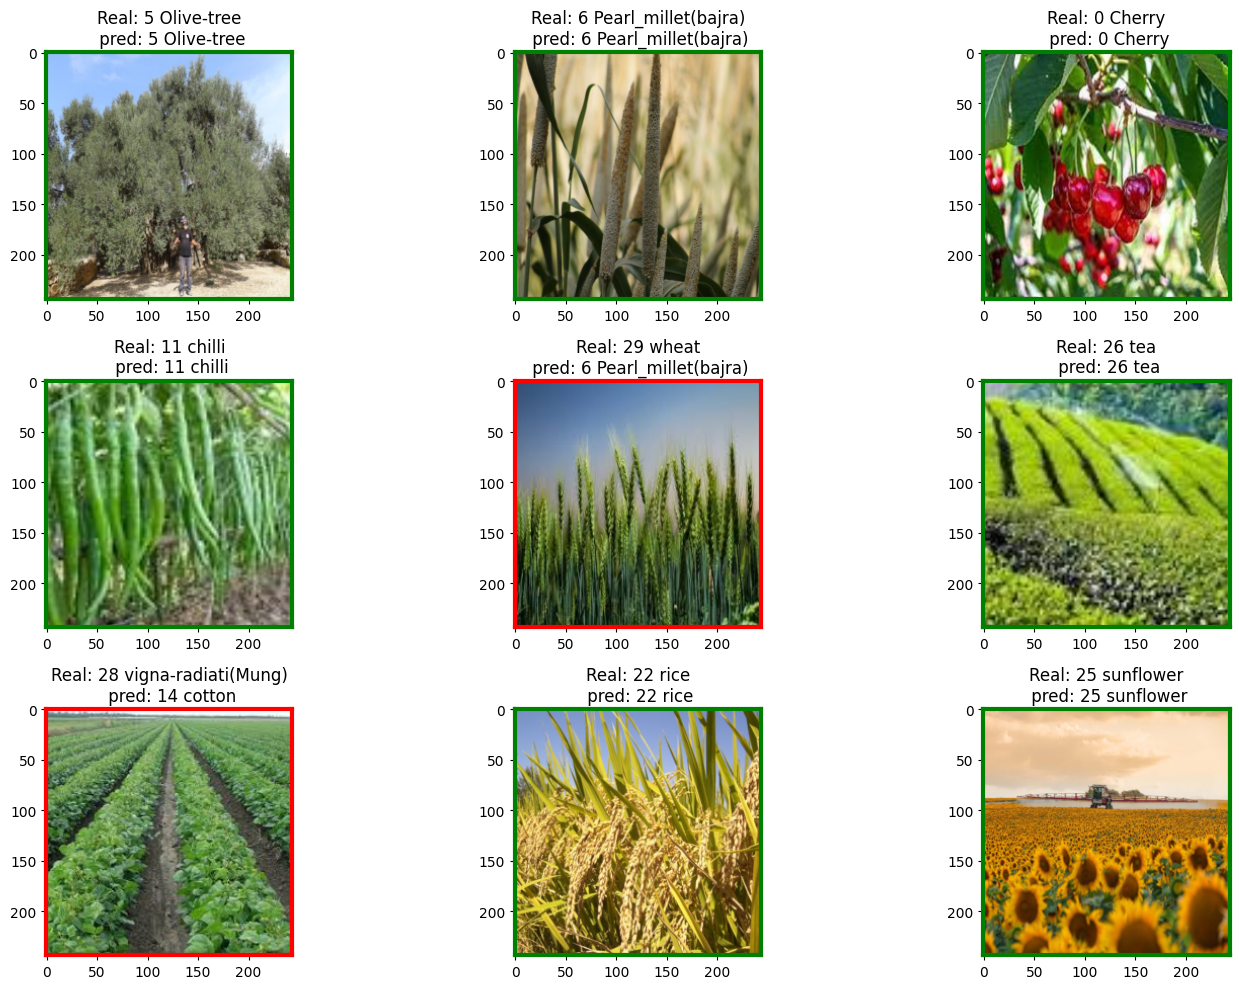

In [226]:
# Берём первый батч
images, labels = next(iter(valid_loader))

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
ax = ax.flatten()

model.eval()
with torch.no_grad():
    preds = model(images.to(DEVICE)).argmax(dim=1)

    preds = preds.cpu().numpy()
    labels= labels.cpu().numpy()

for i in range(9):
  if preds[i] == labels[i]:
    color='green'
  else:
    color='red'

  ax[i].imshow(images[i].permute(1, 2, 0))
  ax[i].set_title(f'Real: {labels[i]} {classes_dict[labels[i]]}\n pred: {preds[i]} {classes_dict[preds[i]]}')

  ax[i].spines['bottom'].set_color(color)
  ax[i].spines['top'].set_color(color)
  ax[i].spines['left'].set_color(color)
  ax[i].spines['right'].set_color(color)
  ax[i].spines['bottom'].set_linewidth(3)
  ax[i].spines['top'].set_linewidth(3)
  ax[i].spines['left'].set_linewidth(3)
  ax[i].spines['right'].set_linewidth(3)

plt.tight_layout()
plt.show()

8. "Разморозь" несоклько слоев базовой модели и вновь обучи ее. Зафиксируй метрику качества для модели. О том, как сделать unfreeze нескольких слоев сразу, а не только последнего, можно почитать тут: [discuss.pytorch.org](https://discuss.pytorch.org/t/how-the-pytorch-freeze-network-in-some-layers-only-the-rest-of-the-training/7088/3)

In [ ]:
model_second = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)

In [ ]:
model_second

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
model_second.classifier[2] = nn.Linear(in_features=768, out_features=10, bias=True)

In [ ]:
for param in model_second.parameters():
  param.requires_grad=False

In [ ]:
for param in model_second.features[7].parameters():
  param.requires_grad=True

In [ ]:
for i in model_second.features[7]:
  print(i)

CNBlock(
  (block): Sequential(
    (0): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
    (1): Permute()
    (2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (3): Linear(in_features=768, out_features=3072, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=3072, out_features=768, bias=True)
    (6): Permute()
  )
  (stochastic_depth): StochasticDepth(p=0.08823529411764706, mode=row)
)
CNBlock(
  (block): Sequential(
    (0): Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)
    (1): Permute()
    (2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (3): Linear(in_features=768, out_features=3072, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=3072, out_features=768, bias=True)
    (6): Permute()
  )
  (stochastic_depth): StochasticDepth(p=0.09411764705882353, mode=row)
)
CNBlock(
  (block): Sequential(
    (0): Conv2d(768, 768, kernel_size=(7, 7), stri

In [ ]:
for param in model_second.classifier.parameters():
  param.requires_grad=True

In [ ]:
model_second.to(DEVICE)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer_second = torch.optim.Adam(model_second.parameters(), lr=0.003)

In [ ]:
for param in model_second.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

In [ ]:
second_model = fit(model_second, 5, optimizer_second, train_loader, valid_loader)

KeyboardInterrupt: 

9. Сравни качество двух моделей: предобученной с замененным выходным слоем и дообученной с несколькими размороженными слоями.

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0].plot(history_model['train_loss'], label='Train loss, last layer', color='blue', )
ax[0].plot(history_model['valid_loss'], label='Valid loss, last layer', color='blue', linestyle=':')

ax[0].grid(True)
ax[0].set_title(f'Loss')
ax[0].set_ylim((0, 0.5))
ax[0].legend()

ax[1].plot(history_model['train_metric'], label='Train accuracy, last layer', color='pink')
ax[1].plot(history_model['valid_metric'], label='Valid accuracy, last layer', color='pink', linestyle=':')

ax[1].grid(True)
ax[1].set_title(f'Accuracy')
ax[1].set_ylim((0.85, 1))
ax[1].legend()

NameError: name 'plt' is not defined

<img src="https://icons.iconarchive.com/icons/icons8/windows-8/256/Programming-Github-icon.png" width=32 /> Сохрани файл для __github__ и распечатай результат команды `!git status` в ячейке ниже.

In [ ]:
# code

10. Сохрани модель (пример можно посмотреть [тут](../../learning/aux/model_saving.ipynb) или в [документации](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [ ]:
PATH = "/my_torch_model.pth"  # .pth или .pt - общепринятые расширения
torch.save(model.state_dict(), PATH)

# 2. Сохраняем ВСЮ модель (менее предпочтительно, но иногда удобно)
# Сохраняет и веса, и архитектуру. Может быть проблематично при изменении кода класса.
PATH_FULL = "/my_torch_model_full.pth"
torch.save(model, PATH_FULL)

NameError: name 'model' is not defined

11. Реализуй функцию, которая на вход принимает путь к файлу, а в ответ возвращает класс объекта.

In [ ]:
def get_prediction(path: str) -> str:
    pass

12. Сохрани ноутбук на github

/content/drive/MyDrive


 08-04-task.ipynb  'Colab Notebooks'/   test/
 archive.zip        _data.gsheet        train/
